In [1]:
#import neccessary libraries
import numpy as np
import pandas as pd
import csv
import scipy.stats

In [2]:
#read noise distribution of desired particle to do energy resolution on for a given energy level
root_file = 'Gamma-E25-n1000-part9'
df = pd.read_csv('cluster-noise-distribution_'+root_file+'.csv')
df

,noise,n_events,n_clusters_mean
0,0.05,1000,7.11
1,0.10,1000,3.46
2,0.15,1000,2.74
3,0.20,1000,2.41
4,0.25,1000,2.36
5,0.30,1000,2.44
6,0.35,1000,2.62
7,0.40,1000,2.93
8,0.45,1000,3.40
9,0.50,1000,3.91


In [3]:
#read cluster info file for a given particle with a given noise level
noise = df['noise'][df['n_clusters_mean'].idxmin()]
df_ci = pd.read_csv('cluster-info_'+root_file+'_noise-'+str(noise)+'.csv')
df_ci

,event_n,event_clusters,n_hits,energy_value
0,0,0,18185,144.778
1,0,9,6,0.046
2,0,18,1,0.017
3,0,75,276,23.510
4,1,0,17719,141.664
...,...,...,...,...
2357,997,26,276,25.103
2358,998,0,18270,144.978
2359,998,55,212,22.524
2360,999,0,17902,143.997


In [4]:
#group by events to get the cluster with the 2nd max number of hits (i.e the first cluster not counting the noise)
#for each event and their energy
df_he = df_ci.drop(df_ci.groupby(df_ci['event_n'])['n_hits'].idxmax()) #drop noise clusters (clusters with max n_hits)
df_he = df_he.loc[df_he.groupby(df_ci['event_n'])['n_hits'].idxmax()]  #keep 2nd highest clusters (max signals)
df_he = df_he.drop(['event_n','event_clusters'], axis=1)
df_he = df_he.reset_index(drop=True)
df_he

,n_hits,energy_value
0,276,23.510
1,263,23.291
2,232,23.363
3,257,21.956
4,281,25.341
...,...,...
995,251,23.466
996,251,24.499
997,276,25.103
998,212,22.524


In [5]:
#set up histogram bining
bin_n = 20
bin_width = (np.ceil(df_he['energy_value'].max()) - np.floor(df_he['energy_value'].min()))/bin_n
custom_bins = np.arange(np.floor(df_he['energy_value'].min()), np.ceil(df_he['energy_value'].max()), bin_width)
custom_bins

array([20.  , 20.55, 21.1 , 21.65, 22.2 , 22.75, 23.3 , 23.85, 24.4 ,
       24.95, 25.5 , 26.05, 26.6 , 27.15, 27.7 , 28.25, 28.8 , 29.35,
       29.9 , 30.45])

In [6]:
#set up bins weights so that summing the bars up gives 1
bin_weights = np.ones_like(df_he['energy_value']) / len(df_he['energy_value'])

In [7]:
#fit data to gaussian distribution
mu, std = scipy.stats.norm.fit(df_he['energy_value'])
g = scipy.stats.norm.pdf(custom_bins, mu, std)

In [8]:
#get fit weight correction for weighted/density histogram
sums_w, bins_w = np.histogram(df_he['energy_value'], custom_bins, weights = bin_weights)
sums_d, bins_d = np.histogram(df_he['energy_value'], custom_bins, density = True)
g_weight = np.amax(sums_w)/np.amax(sums_d)

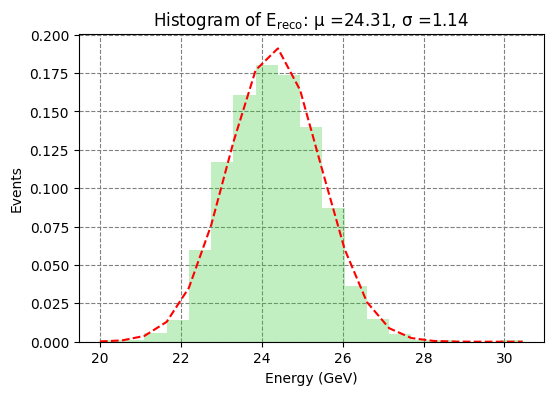

In [9]:
#set x-axis limits so that histogram is centered
xmin = 0
xmax = np.ceil(mu)*2

#plot histogram 
ax = df_he.plot('n_hits', 
        kind='hist', 
        bins=custom_bins,
        density=False,
        weights = bin_weights,
        title = 'Histogram of $\mathregular{E_{reco}}$: μ ='+str(np.round(mu,2))+', σ ='+str(np.round(std,2)),
        ylabel = 'Events', 
        xlabel='Energy (GeV)',
        rot = 0,
        color='limegreen',
        legend = None,
        figsize=(6, 4),
        alpha=0.3)

#plot gaussian fit
ax.plot(custom_bins, g*g_weight, color='red', linestyle='dashed')

#set plot parameters
ax.set_axisbelow(True)
#ax.set_xlim([xmin, xmax]) #uncomment for centered histogram
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.get_figure().savefig('energy-distribution-'+root_file+'_noise-'+str(noise)+'.png', bbox_inches = 'tight')